In [74]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.stats import LombScargle
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable


plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [10]:
df = pd.read_csv("CV_periods.csv", skiprows=53)
df.head()

,Name,AltName,RAJ2000,DEJ2000,Type1,Type2,mag1,Orb_Per,SpType2,SpType1,Refs
0,V1017 Sgr,N Sgr 1919,18 32 04.5,-29 23 12,Nb,DN,13.7,5.714000,G5/3p,,Refs
1,MR Vel,0925-4758,09 25 45.9,-47 58 18,SS,,17.0,4.028782,,,Refs
2,V630 Cas,N Cas 1950,23 48 51.9,+51 27 39,DN,,16.2,2.563870,K4-5,,Refs
3,EQ CMa,,06 48 51.6,-16 18 03,CV,,11.9,2.291500,,,Refs
4,GK Per,N Per 1901,03 31 12.0,+43 54 16,Na,DN,12.8,1.996803,K1/4,,Refs


In [17]:
periods = np.zeros((len(df)))
for i, p in enumerate(df.Orb_Per.values):
    try:
        periods[i] = float(p)
    except:
        print(p)

Text(0.5,0,'Orbital period [hrs]')

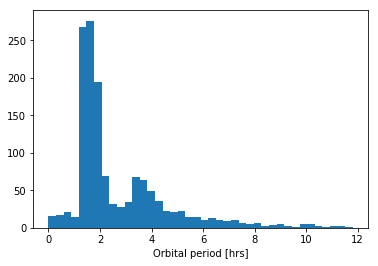

In [25]:
periods_hours = periods * 24
m = periods_hours < 12
plt.hist(periods_hours[m], 40);
plt.xlabel("Orbital period [hrs]")

In [53]:
def make_light_curve(period_days, amplitude, phase, cadence_minutes=5, precision=5, baseline=20, nights=True):
    """
    period_days is the period in days
    amplitude is the amplitude in percent
    phase is the phase in radians.
    """
    
    cadence = cadence_minutes/(24*60)  # 30 minute cadence in days
    t = np.arange(0, baseline, cadence)  # times at which to calculate light curve [days]

    if nights:
        times = []
        for i in range(baseline):
            n = 24*i < t*24
            n &= t*24 < 24*i + 6
            times += list(t[n])
        t = np.array(times)
    
    f = 1./period_days
    y = 1 + amplitude*1e-2*np.sin(2*np.pi*f*t + phase)
    
    f = y + np.random.randn(len(t))*precision*1e-2
    return t, f

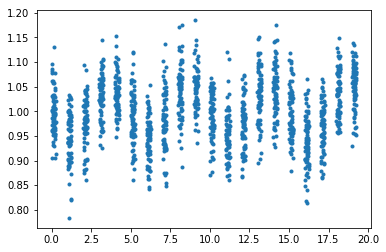

In [57]:
x, y = make_light_curve(5, 5, np.pi, nights=True)
plt.plot(x, y, ".")

Draw periods and amplitudes from logarithmic distributions.

In [83]:
Ntrials = 24
Namps = 8
Npers = 16
amps = 10**np.linspace(.01, 1, Namps)
pers = 10**np.linspace(.5/24, 1, Npers)
recovered, true_p = [np.zeros((Npers, Namps, Ntrials)) for i in range(2)]

In [84]:
def run_ls(Ntrials, pers, amps):
    Npers, Namps = len(pers), len(amps)
    for k in tqdm(range(Ntrials)):
        for i in range(Npers):
            for j in range(Namps):
                t, f = make_light_curve(pers[i], amps[j], phase=np.pi)
                frequency, power = LombScargle(t, f).autopower()
                period = 1./frequency
                recovered[i, j, k] = period[power == max(power)][0]
                true_p[i, j, k] = pers[i]
    return recovered, true_p
            
#                 # Make plots
#                 plt.plot(periodogram.period, periodogram.power)
#                 plt.axvline(porbs[i], color="tab:orange", ls="--")
#                 plt.savefig("plots/{0}{1}{2}".format(i, j, k))
#                 plt.close()
#                 plt.plot(t, f, ".")
#                 plt.savefig("plots/{0}{1}{2}_lc".format(i, j, k))
#                 plt.close()
run_ls(Ntrials, pers, amps)

100%|██████████| 24/24 [01:28<00:00,  3.98s/it]


(array([[[6.22329664e-03, 5.15899613e-01, 1.04016517e+00, ...,
          2.74900794e+01, 1.04016517e+00, 1.05153309e+00],
         [1.04016517e+00, 5.10425877e-01, 5.13148148e-01, ...,
          1.04016517e+00, 1.04016517e+00, 1.05153309e+00],
         [1.04016517e+00, 1.05153309e+00, 1.04016517e+00, ...,
          2.74900794e+01, 1.05153309e+00, 1.04016517e+00],
         ...,
         [1.05153309e+00, 1.05153309e+00, 1.05153309e+00, ...,
          1.05153309e+00, 1.05153309e+00, 1.05153309e+00],
         [1.05153309e+00, 1.05153309e+00, 1.05153309e+00, ...,
          1.05153309e+00, 1.05153309e+00, 1.05153309e+00],
         [1.05153309e+00, 1.05153309e+00, 1.05153309e+00, ...,
          1.05153309e+00, 1.05153309e+00, 1.05153309e+00]],
 
        [[1.21025507e+00, 1.24148746e+00, 5.48235201e-01, ...,
          1.21025507e+00, 1.21025507e+00, 1.22567233e+00],
         [1.21025507e+00, 1.21025507e+00, 1.22567233e+00, ...,
          1.22567233e+00, 1.22567233e+00, 1.22567233e+00],
       

In [81]:
def make_plot(true_p, recovered, pers, amps, Ntrials):
    Npers, Namps = len(pers), len(amps)
    
    success = true_p/abs(true_p - recovered)
    success_hist = np.zeros((Npers, Namps))

    for i in range(Npers):
        for j in range(Namps):
            success = abs(true_p[i, j, :] - recovered[i, j, :])/true_p[i, j, :]
            s = success <= .1
            success_hist[i, j] = float(sum(s))/Ntrials
        
    fig, ax = plt.subplots(figsize=(Namps*1, Npers*1))
    img = ax.imshow(success_hist, extent=[amps[0], amps[-1], pers[1], pers[0]], aspect="auto")
#     tlabels = []
#     tmarks = np.linspace(pers[0], 1.5, Npers)
#     for p in pers:
#         tlabels.append("${0:.3}$".format(p))
#     ax.set_yticks(tmarks)
#     ax.set_yticklabels(tlabels)
#     plt.xlabel("$\mathrm{Period}$")
#     plt.ylabel("$\mathrm{Amplitude}$")

#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)

    #plt.colorbar(img, ax=ax, cax=cax, label="$\mathrm{Fraction~recovered}$")
    plt.savefig("test.pdf")

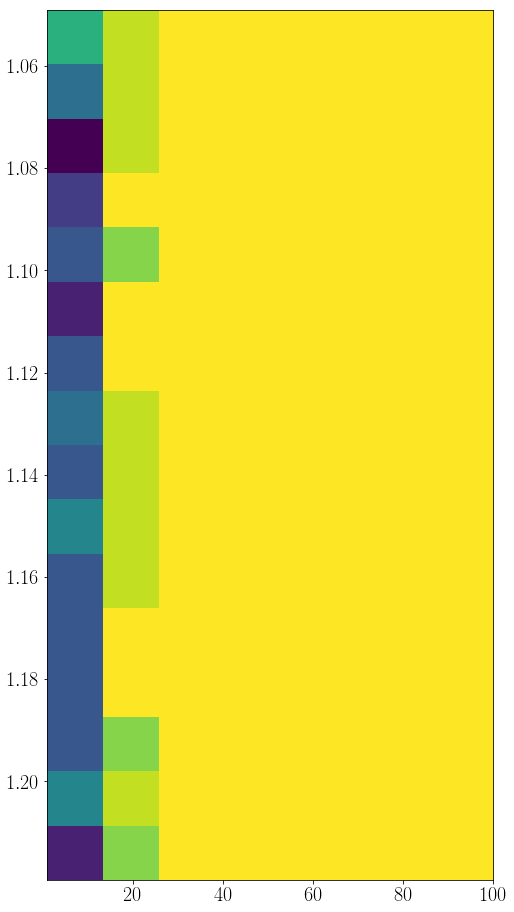

In [82]:
make_plot(true_p, recovered, pers, amps, Ntrials)